In [31]:
import os
import random
from os.path import join
from queue import Queue
import concurrent.futures
import math


from numpy import load
import numpy as np
import glob
import cv2

from PIL import Image
from IPython.display import display

In [32]:
FULL_DEG = 360

CONFIG ={
    'src_path':"miniimagenet_1000",
    'dst_path':"saved_folder",
    'img_type': [
        "*.jpg",
        "*.png",
        "*.gif"
    ],
    'num_workers':8
}

In [33]:
def rotate_image(img_path):
    """
    Image rotation function which takes a single image and randomly rotates it
    :param: str image_path: path of the image
    :returns: ndarray : 3D rotated array
    """

    degrees_rotate = random.randint(0,FULL_DEG)
    rotation_rad = degrees_rotate*(np.pi/180.0)
    img = cv2.imread(img_path)
    Height,Width,Channel = img.shape
    rot_size = int(np.sqrt(Height**2+Width**2))
    rotated_img_array = np.zeros((rot_size,rot_size,Channel))

    mid_row = int((rot_size+1)/2)
    mid_col = int((rot_size+1)/2)

    for row_y in range(rot_size):
        for col_x in range(rot_size):
            '''
            Via the Rotation matrix:
            [[cos\theta  -sin\theta]
             [sin\theta  cos\theta]]
            '''
            y = (row_y-mid_col)*math.cos(rotation_rad) + (col_x - mid_row)*math.sin(rotation_rad)

            x = -(row_y-mid_col)*math.sin(rotation_rad) + (col_x - mid_row)*math.cos(rotation_rad)

            y += mid_col
            x += mid_row

            x = round(x)
            y = round(y)
            
            # Equate corresponding pixel of the rotated coordinates
            if (x>=0 and y>=0 and x<Width and y<Height):
                rotated_img_array[row_y][col_x][:] = img[y][x][:]
    return rotated_img_array

In [34]:
def save_to_npz(arr_images,dst_path,name='first'):
    """
    Saves an image array to a compressed .npz file
    :param: ndarray arr_images: 4D ndarray corresponding to Image Index-WIDTH-HEIGHT-Channel
    :param: str dst_path : destination directory where to save the .npz file
    :param: str name: identifier of the npz archive
    :returns: str: path of the saved npz archive
    """
    dst_path = join(dst_path,name)
    np.savez_compressed(dst_path,a=arr_images)
    dst_path = dst_path+'.npz'
    return dst_path


In [35]:
def load_display_data(npz_path):
    """
    Load the .npz archive and randomly display an image
    :param: str npz_path: path of the .npz archive
    :returns: None
    """
    with load(npz_path) as data:
        img_array = data['a'][random.randint(0,len(data['a']))]
        display(Image.fromarray(np.uint8(img_array)).convert('RGB'))

In [36]:
def main(CONFIG):
    """
    Where the Multithread Executor executes the rotate_image operation with a list of input parameters
    :parameter: dict CONFIG: 
    """
    img_paths = []
    source_path = join(os.getcwd(),CONFIG['src_path'])
    for file_type in CONFIG['img_type']:
        img_paths.extend(glob.glob(source_path+'/'+file_type))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        rotated_images_arr = np.stack([arr_img for arr_img in executor.map(rotate_image,img_paths)])
        random.shuffle(rotated_images_arr)

    dst_path = join(os.getcwd(),CONFIG['dst_path'])
    if not os.path.exists(dst_path):
        os.makedirs(dst_path,exist_ok=True)
    npz_names = [
        "first",
        "second",
        "third",
        "fourth"
    ]

    npz_paths = []
    for i,npz_name in enumerate(npz_names):
        archive_array = rotated_images_arr[i*len(rotated_images_arr)//4:(i+1)*len(rotated_images_arr)//4]
        npz_path = save_to_npz(archive_array,dst_path,npz_name)
        npz_paths.append(npz_path)

    for npz_path in npz_paths:
        load_display_data(npz_path)

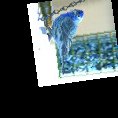

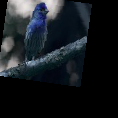

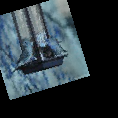

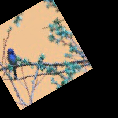

In [37]:
if __name__ == '__main__':
    main(CONFIG)